## <center> <font color='blue'> <b> Long Distance Problem </b> </font> </center>

The goal is to prove that the LSTMs can handle long sequences.

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tensorflow.keras.layers import Input, Dense, SimpleRNN, GRU, LSTM, GlobalMaxPool1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

### Helper Functions

In [94]:
# plot loss and accuracy
def plot_loss_and_accuracy(history):
    """
    Plots the loss and accuracy from a single training history side by side.

    Parameters:
    - history: Training history object.
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    axs[0].plot(history.history['loss'], label='Loss (Train)')
    axs[0].plot(history.history['val_loss'], label='Loss (Val)')
    axs[0].set_title('Loss')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    # Plot accuracy
    axs[1].plot(history.history['accuracy'], label='Accuracy (Train)')
    axs[1].plot(history.history['val_accuracy'], label='Accuracy (Val)')
    axs[1].set_title('Accuracy')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

### Build the dataset

This function below can be used to assign a label (either 1 or 0) to a set of three values based on their sign (positive or negative). The conditions check for certain patterns of negativity and positivity among the values at i1, i2, and i3.

In [3]:
def get_labels(x, i1, i2, i3):
    if x[i1] < 0 and x[i2] < 0 and x[i3] < 0:
        return 1
    if x[i1] < 0 and x[i2] > 0 and x[i3] > 0:
        return 1
    if x[i1] > 0 and x[i2] < 0 and x[i3] > 0:
        return 1
    if x[i1] > 0 and x[i2] > 0 and x[i3] < 0:
        return 1
    return 0


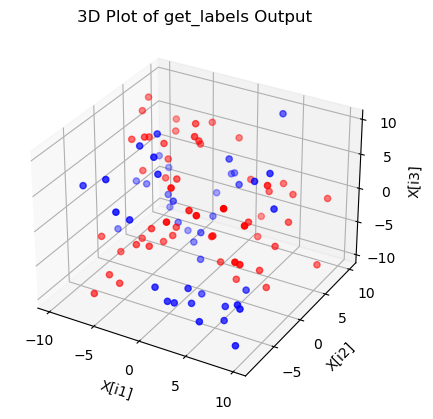

In [7]:
# let's plot this with example data

# Generate some random data for x
n_points = 100
x = np.random.uniform(-10, 10, (n_points, 3))  # Random points in 3D space

# Calculate labels for each point using get_labels
labels = [get_labels(x[i], 0, 1, 2) for i in range(n_points)]

# Set up the 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors for labels 0 and 1
colors = ['red' if label == 1 else 'blue' for label in labels]
ax.scatter(x[:, 0], x[:, 1], x[:, 2], c=colors, marker='o')

# Set labels for the axes
ax.set_xlabel('X[i1]')
ax.set_ylabel('X[i2]')
ax.set_zlabel('X[i3]')

plt.title('3D Plot of get_labels Output')
plt.show()


In [20]:
T = 10
D = 1

In [21]:
def build_dataset(i1, i2, i3, T=T, D=D):
    X = []
    Y = []
    for t in range(5000):
        x = np.random.randn(T)
        X.append(x)
        y = get_labels(x, i1, i2, i3)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    N = len(X)
    return X, Y, N

# short memory data
Xs, Ys, Ns = build_dataset(-1, -2, -3) # last 3 values

# long memory data
Xl, Yl, Nl = build_dataset(0, 1, 2) # first 3 values  

In [22]:
Xs.shape, Ys.shape, Xl.shape, Yl.shape

((5000, 10), (5000,), (5000, 10), (5000,))

### Model 1 - Linear Model

We're going to try a linear model first. We will see that is not going to get good results.

In [32]:
def build_compile_model1(T):
    # Define the input layer
    i = Input(shape=(T,))
    
    # Define the dense layer with sigmoid activation
    x = Dense(1, activation='sigmoid')(i)
    
    # Create the model
    model = Model(inputs=i, outputs=x)

    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.01),
        metrics=['accuracy']
    )
    
    return model

In [33]:
model1 = build_compile_model1(T)

In [37]:
# train for the short memory problem
r = model1.fit(
        Xs, Ys,
        epochs=100,
        verbose=0,
        validation_split=0.2, # take 20% of the data to validate
        #shuffle=True  Not for time series!!!
)

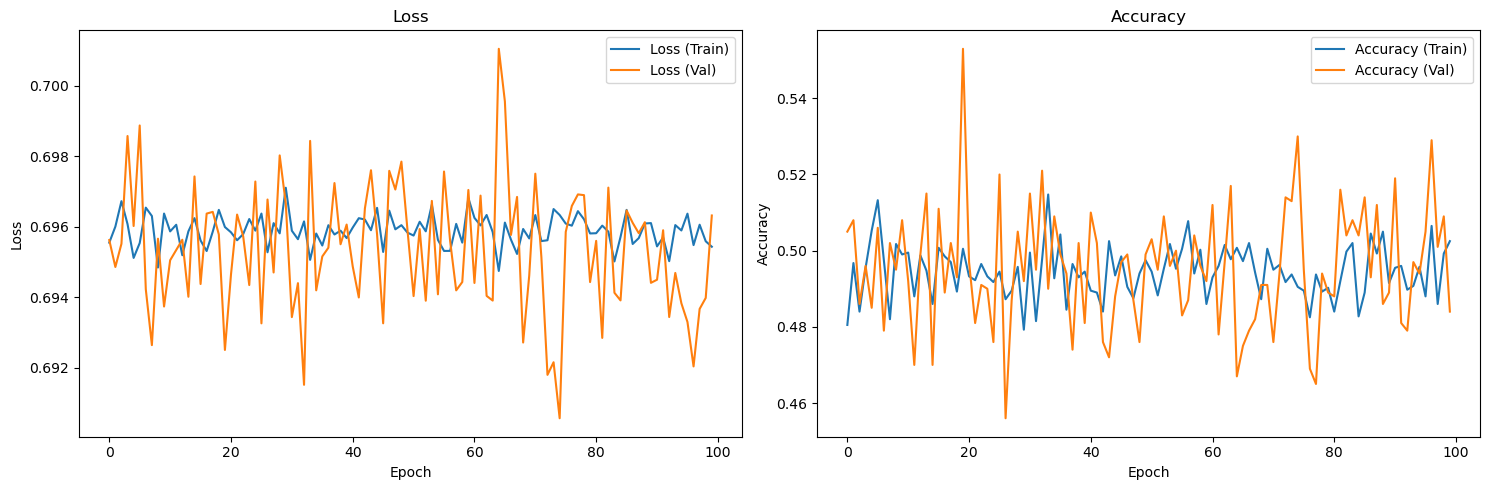

In [96]:
plot_loss_and_accuracy(r)

In [43]:
r.history['val_accuracy'][-1]

0.48399999737739563

The model is terrible, its validation accuracy is less than 50%. 

### Model 2 - SimpleRNN

In [47]:
# We need to reshape the input first
Xs_rnn = np.expand_dims(Xs, -1)
Xl_rnn = np.expand_dims(Xl, -1)

In [48]:
Xs_rnn.shape, Xl_rnn.shape

((5000, 10, 1), (5000, 10, 1))

In [49]:
def build_compile_model2(T, D):
    # Define the input layer
    i = Input(shape=(T, D))
    
    # Simple RNN
    x = SimpleRNN(5)(i)
    
    #output layer
    x = Dense(1, activation='sigmoid')(x)
    
    # Create the model
    model = Model(inputs=i, outputs=x)
    
    
    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.01),
        metrics=['accuracy']
    )
    
    return model

In [51]:
model2 = build_compile_model2(T, D)

In [52]:
# train for the short memory problem
r2 = model2.fit(
        Xs_rnn, Ys,
        epochs=100,
        verbose=0,
        validation_split=0.2, # take 20% of the data to validate
)

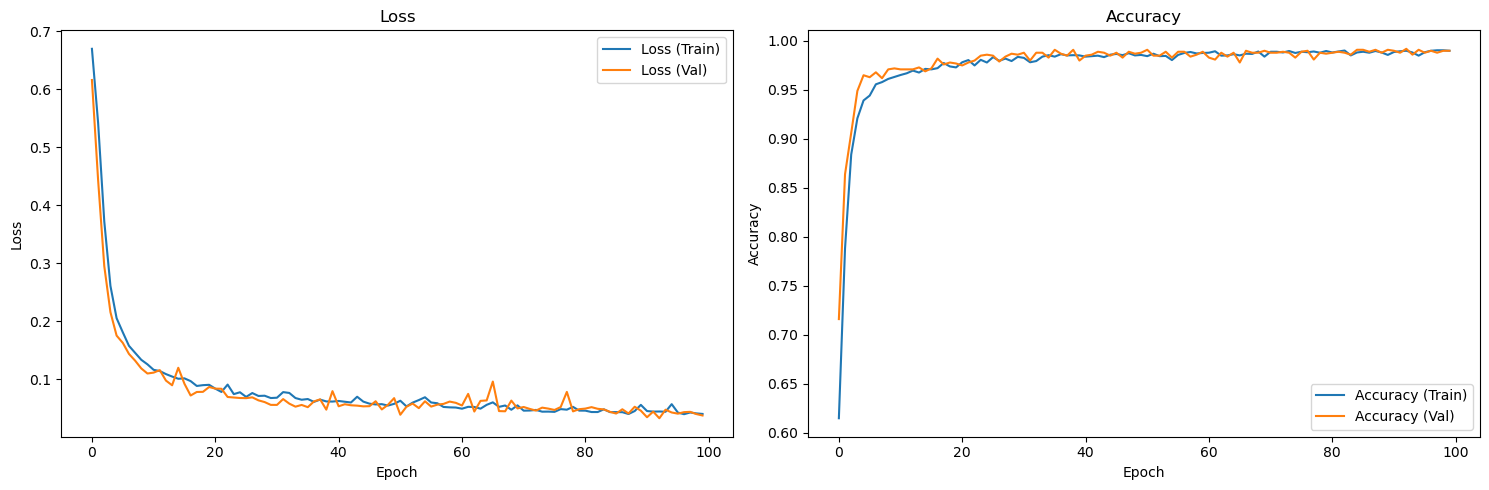

In [97]:
plot_loss_and_accuracy(r2)

In [56]:
r2.history['val_accuracy'][-1]

0.9900000095367432

Much better. Let's see how we do now with long-term dependencies.

In [57]:
# train for the long memory problem
r3 = model2.fit(
        Xl_rnn, Yl,
        epochs=100,
        verbose=0,
        validation_split=0.2, # take 20% of the data to validate
)

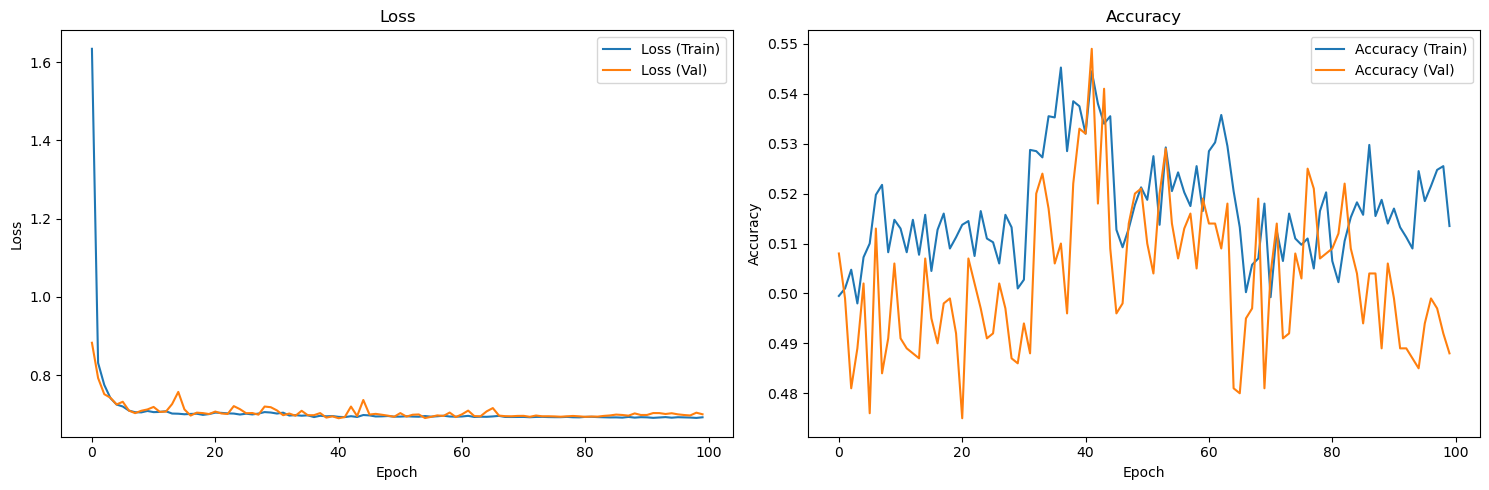

In [98]:
plot_loss_and_accuracy(r3)

In [61]:
r3.history['val_accuracy'][-1]

0.4880000054836273

Not very good results, let's try with an LSTM now.

### Model 3 - LSTM

In [62]:
def build_compile_model3(T, D):
    # Define the input layer
    i = Input(shape=(T, D))
    
    # Simple RNN
    x = LSTM(5)(i)
    
    #output layer
    x = Dense(1, activation='sigmoid')(x)
    
    # Create the model
    model = Model(inputs=i, outputs=x)
    
    
    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.01),
        metrics=['accuracy']
    )
    
    return model

In [63]:
model3 = build_compile_model3(T, D)

In [64]:
# train for the long memory problem
r4 = model3.fit(
        Xl_rnn, Yl,
        epochs=100,
        verbose=0,
        validation_split=0.2, # take 20% of the data to validate
)

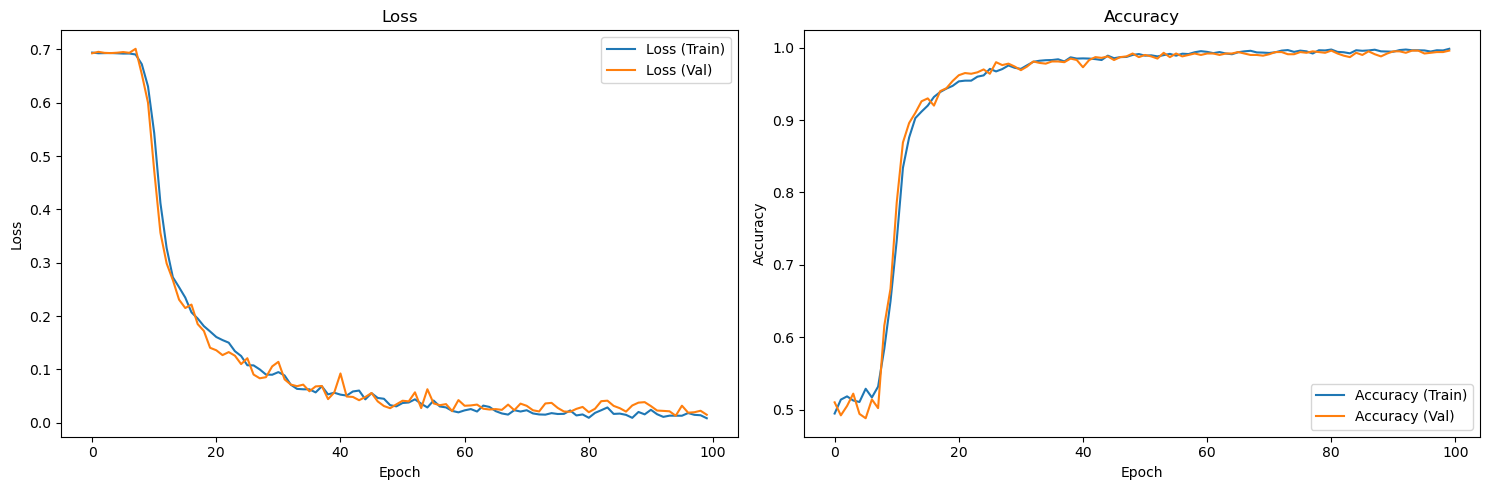

In [99]:
plot_loss_and_accuracy(r4)

In [68]:
r4.history['val_accuracy'][-1]

0.9959999918937683

Great!! Now let's see what happens if we increase T.

In [69]:
def build_dataset(i1, i2, i3, T=T, D=D):
    X = []
    Y = []
    for t in range(5000):
        x = np.random.randn(T)
        X.append(x)
        y = get_labels(x, i1, i2, i3)
        Y.append(y)
    X = np.array(X)
    Y = np.array(Y)
    N = len(X)
    return X, Y, N


# long memory data
Xl, Yl, Nl = build_dataset(0, 1, 2, 30) # now T it's 30

In [70]:
Xl_rnn = np.expand_dims(Xl, -1)

In [73]:
model3 = build_compile_model3(30, D)

In [74]:
# train for the long memory problem
r5 = model3.fit(
        Xl_rnn, Yl,
        epochs=100,
        verbose=0,
        validation_split=0.2, # take 20% of the data to validate
)

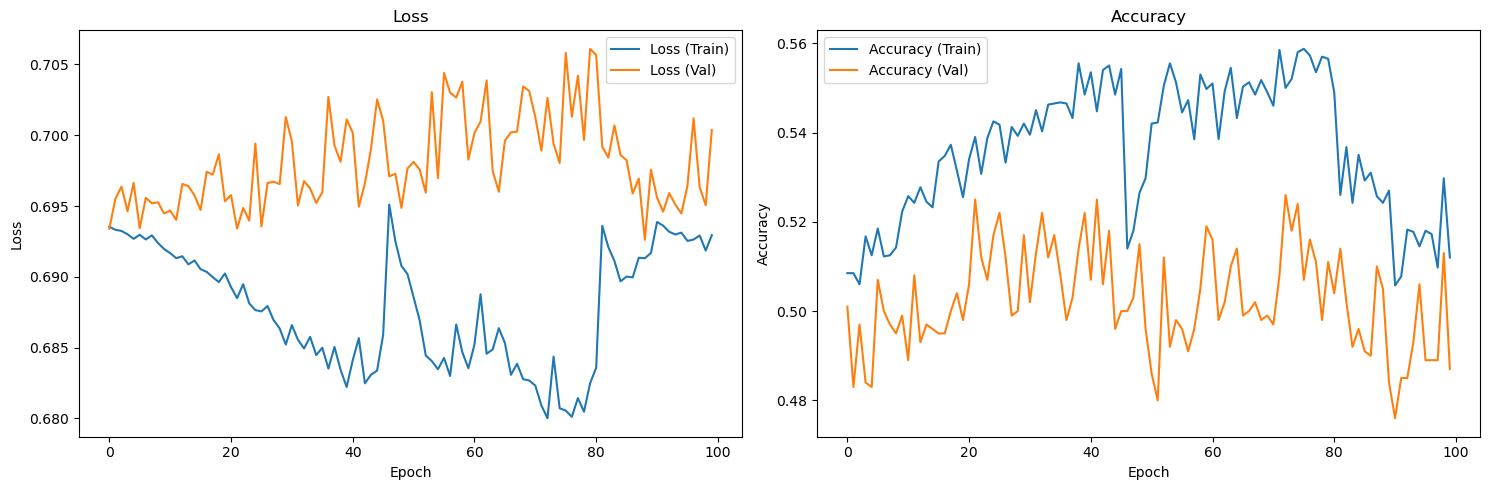

In [100]:
plot_loss_and_accuracy(r5)

In [78]:
r5.history['val_accuracy'][-1]

0.4869999885559082

Not good, let's try with another model.

### Model 4 - LSTM + Global Average Pooling


In [82]:
def build_compile_model4(T, D):
    # Define the input layer
    i = Input(shape=(T, D))
    
    # Simple RNN
    x = LSTM(5, return_sequences=True)(i)
    x = GlobalMaxPool1D()(x)
    
    
    #output layer
    x = Dense(1, activation='sigmoid')(x)
    
    # Create the model
    model = Model(inputs=i, outputs=x)
    
    
    # Compile the model
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.01),
        metrics=['accuracy']
    )
    
    return model

In [83]:
model4 = build_compile_model4(30, D)

In [84]:
# train for the long memory problem
r6 = model4.fit(
        Xl_rnn, Yl,
        epochs=100,
        verbose=0,
        validation_split=0.2, # take 20% of the data to validate
)

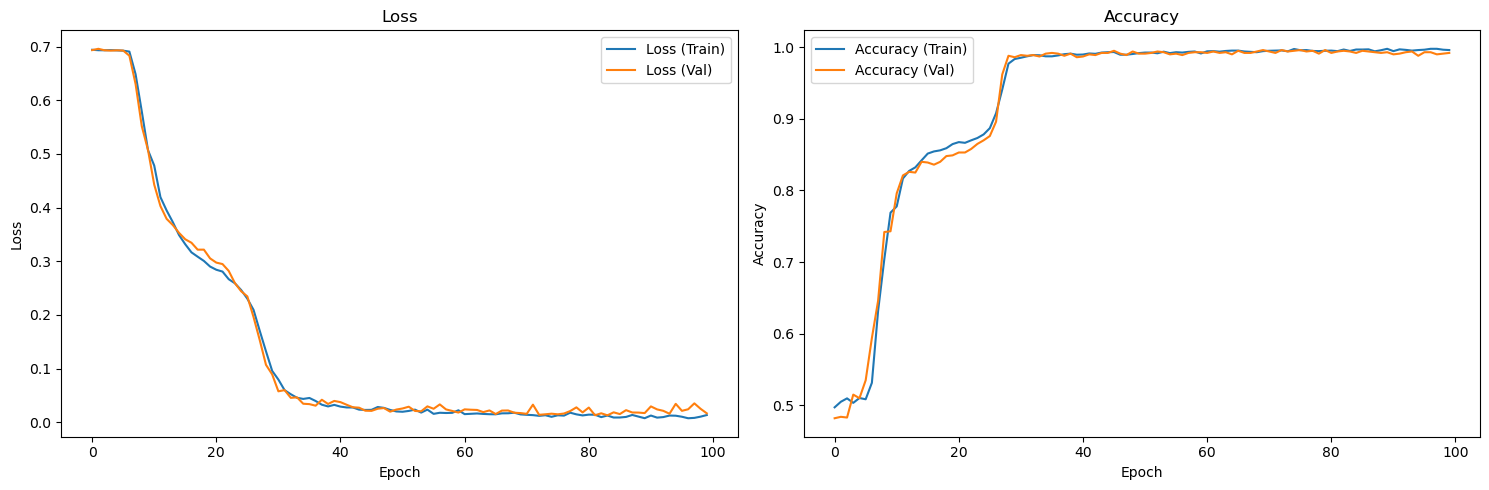

In [101]:
plot_loss_and_accuracy(r6)

In [89]:
r6.history['val_accuracy'][-1]

0.9919999837875366

Great!!

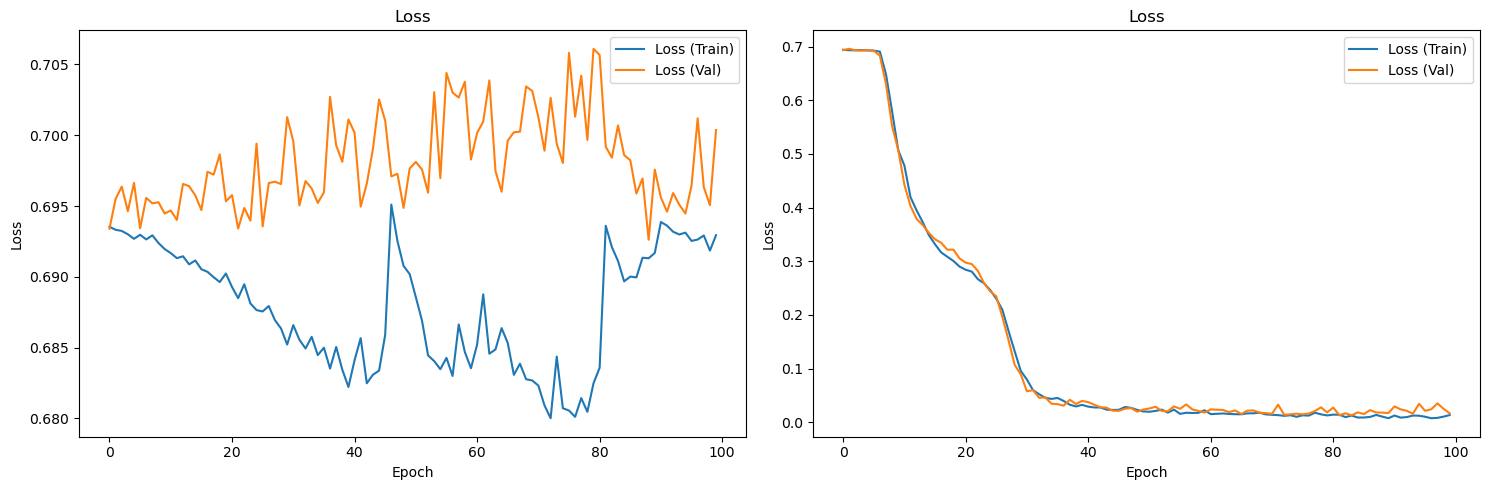

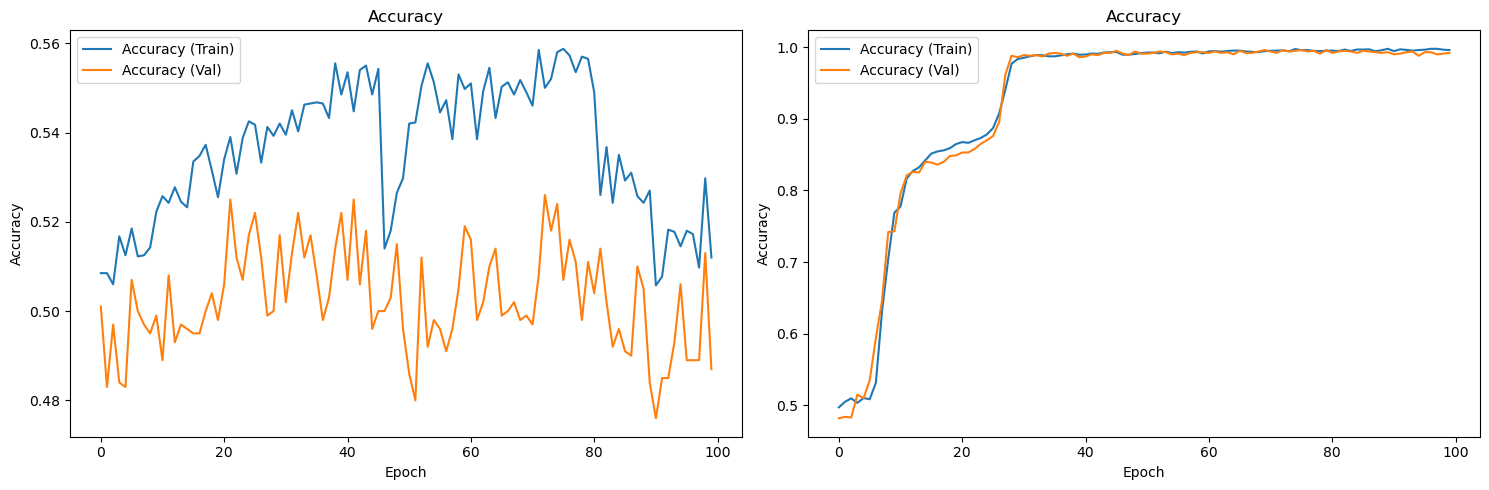

In [91]:
# Plot to compare models

def plot_metrics(history1, history2, metric='loss'):
    """
    Plots training and validation metrics (loss or accuracy) from two different training histories side by side.

    Parameters:
    - history1: First training history object (e.g., r5).
    - history2: Second training history object (e.g., r6).
    - metric: Metric to plot ('loss' or 'accuracy').
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    if metric == 'loss':
        axs[0].plot(history1.history['loss'], label='Loss (Train)')
        axs[0].plot(history1.history['val_loss'], label='Loss (Val)')
        axs[0].set_title('Loss')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Loss')
        axs[0].legend()

        axs[1].plot(history2.history['loss'], label='Loss (Train)')
        axs[1].plot(history2.history['val_loss'], label='Loss (Val)')
        axs[1].set_title('Loss')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Loss')
        axs[1].legend()

    # Plot accuracy
    elif metric == 'accuracy':
        axs[0].plot(history1.history['accuracy'], label='Accuracy (Train)')
        axs[0].plot(history1.history['val_accuracy'], label='Accuracy (Val)')
        axs[0].set_title('Accuracy')
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Accuracy')
        axs[0].legend()

        axs[1].plot(history2.history['accuracy'], label='Accuracy (Train)')
        axs[1].plot(history2.history['val_accuracy'], label='Accuracy (Val)')
        axs[1].set_title('Accuracy')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Accuracy')
        axs[1].legend()

    plt.tight_layout()
    plt.show()

# Example usage:
plot_metrics(r5, r6, metric='loss')     # To plot loss metrics
plot_metrics(r5, r6, metric='accuracy') # To plot accuracy metrics
